# Georeferencing

In [51]:
import cameratransform as ct
import pandas as pd
import os
import numpy as np
import rasterio
from PIL import Image
import matplotlib.pyplot as plt
import glob
import micasense.imageset
import micasense.capture
import micasense.imageutils
import cv2
import algorithms.select_GPS as SelectGPS
import importlib
import algorithms.flight_attributes
importlib.reload(algorithms.flight_attributes)
import algorithms.flight_attributes as FlightAttributes

# Define folders

In [2]:
imagePath = r"D:\EPMC_flight\pandanRes\00angle_15H_50overlap"
if os.path.exists(os.path.join(imagePath,'thumbnails')):
    parent_dir = os.path.join(imagePath,'thumbnails')
    fp_list = [os.path.join(parent_dir,fp) for fp in sorted(os.listdir(parent_dir))]

else:
    fp_list = None

rawImagePath = os.path.join(imagePath,'RawImg') # We created a new folder called RawImg to store all the raw images here

## Load panels
- to obtain the cropped dimensions when aligning the band images

c:\Users\PAKHUIYING\anaconda3\envs\micasenseGeoreferencing\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(1, 960, 1280)
(960, 1280)


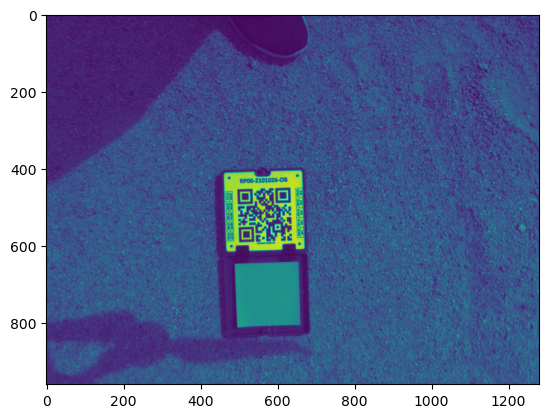

62064

In [6]:
src = rasterio.open(os.path.join(rawImagePath,'IMG_0000_1.tif'))
img = src.read(1)
print(src.read().shape)
print(img.shape)
plt.figure()
plt.imshow(img)
plt.show()
img.max()

## Load stacked images generated from MicaSense's image processing library

c:\Users\PAKHUIYING\anaconda3\envs\micasenseGeoreferencing\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(10, 919, 1239)
(919, 1239)


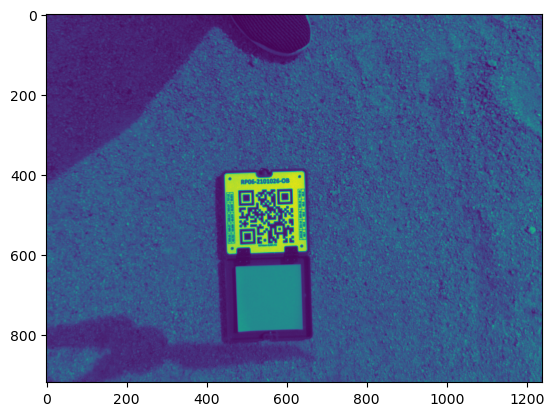

34946

In [15]:
src = rasterio.open(os.path.join(imagePath,'stacks','IMG_0000_1.tif'))
imgStack = src.read(1)
print(src.read().shape)
print(imgStack.shape)
plt.figure()
plt.imshow(imgStack)
plt.show()
imgStack.max()

# Align band images

(4.0, 6.0, 1240.0, 920.0)
5 7 1240 920
(920, 1240)


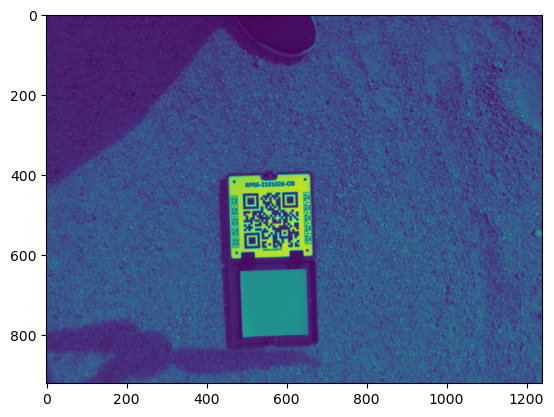

In [16]:
panelNames = glob.glob(os.path.join(rawImagePath,'IMG_0000_*.tif'))
panelCap = micasense.capture.Capture.from_filelist(panelNames)
warp_matrices = panelCap.get_warp_matrices()
cropped_dimensions, _ = micasense.imageutils.find_crop_bounds(panelCap, warp_matrices, warp_mode=cv2.MOTION_HOMOGRAPHY)
print(cropped_dimensions)

(left, top, w, h) = tuple(int(i) for i in cropped_dimensions)
print(left, top, w, h)
im_cropped = img[top:top+h, left:left+w]
print(im_cropped.shape)
plt.figure()
plt.imshow(im_cropped)
plt.show()

In [5]:
ImageHeight, ImageWidth, ImageChannel = np.asarray(Image.open(fp_list[0])).shape
print(f'cropped image height, width, channel: {ImageHeight, ImageWidth, ImageChannel}') # original image of mica sense height and width is 960 and 1280 respectively

log = pd.read_csv(os.path.join(imagePath, 'flight_attributes', 'flight_attributes.csv')) # The log.csv contains geoinformation of the captures
focal = 5.4
image_size = ImageWidth, ImageHeight
lat = log['latitude'][0]
lon = log['longitude'][0]
alt = log['altitude'][0]
pitch = log['dls-pitch'][0]
roll = log['dls-roll'][0]
yaw = log['dls-yaw'][0]
ID = log['image_name'][0]
print(lat,lon,alt,pitch,roll,yaw,ID)
log.head()
log.tail()

cropped image height, width, channel: (919, 1239, 3)
1.3189836 103.7365763 30.643 -0.2079689556400387 -0.0473979544744938 0.635661982536754 IMG_0000_1.tif


,timestamp,latitude,longitude,altitude,image_name,capture_id,dls-yaw,dls-pitch,dls-roll,irr-475,irr-560,irr-668,irr-842,irr-717,irr-444,irr-531,irr-650,irr-705,irr-740
77,2023-09-20 02:42:37.754046+00:00,1.318995,103.736652,52.113,IMG_0077_1.tif,LxWxxE0dKGSKCJPD9emk,-1.710094,-0.109079,-0.110542,0.324510,0.278215,0.215442,0.135719,0.169883,0.300243,0.292801,0.216655,0.190829,0.175554
78,2023-09-20 02:42:40.221641+00:00,1.318985,103.736609,52.254,IMG_0078_1.tif,vOZMfLXGQb0fb52EGfk8,-1.701558,-0.107945,-0.112222,0.322847,0.276751,0.214274,0.134965,0.168932,0.298718,0.291270,0.215472,0.189780,0.174602
79,2023-09-20 02:42:42.735583+00:00,1.318975,103.736563,52.359,IMG_0079_1.tif,o4SQ3aYYcZEyDzjKdJhi,-1.701601,0.009124,-0.105172,0.321727,0.275801,0.213584,0.134510,0.168352,0.297657,0.290258,0.214756,0.189152,0.174039
80,2023-09-20 02:44:00.101050+00:00,1.318983,103.736560,24.732,IMG_0080_1.tif,cbN2MVydgBF9ySm3oP9I,0.578686,-0.115606,-0.048260,0.322058,0.274594,0.213920,0.134003,0.168978,0.296372,0.289454,0.214553,0.190291,0.175322
81,2023-09-20 02:44:06.354370+00:00,1.318983,103.736561,23.956,IMG_0081_1.tif,0Z0tdY0WFSkVPipRkMSL,0.560956,-0.160564,-0.012602,0.321326,0.274137,0.213855,0.133871,0.168757,0.295519,0.288885,0.214373,0.190151,0.175226


# Flight points
- Run `algorithms/select_GPS.py` to interactively select the start and end points of the flight swaths

[10, 15, 19, 25, 29, 35, 39, 45, 49, 55, 59, 65]


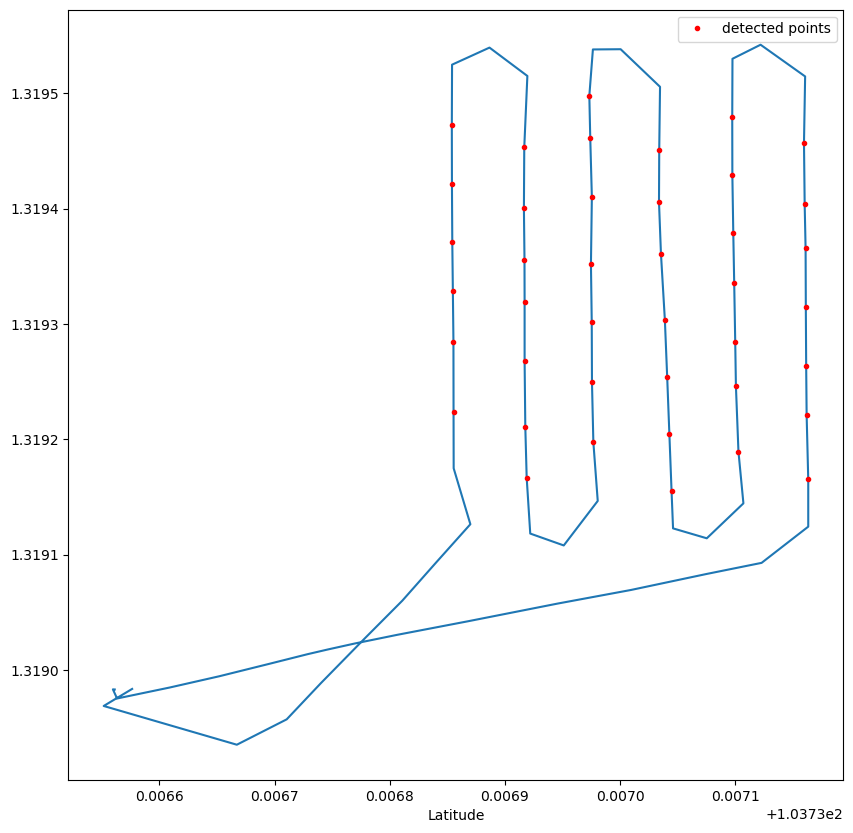

[10, 11, 12, 13, 14, 15, 19, 20, 21, 22, 23, 24, 25, 29, 30, 31, 32, 33, 34, 35, 39, 40, 41, 42, 43, 44, 45, 49, 50, 51, 52, 53, 54, 55, 59, 60, 61, 62, 63, 64, 65]


In [52]:
# import GPS points
ls_idx = SelectGPS.readSelectedGPS(rawImagePath)
# print(ls_idx)
# plot selected GPS points
DL = SelectGPS.DetectLines(log, n = 3, thresh=0.99, plot=True)
flight_points = DL.get_points(flight_points = ls_idx)
print(flight_points)

# Direct georeferencing with Rasterio

This code was modified from [Micasense](https://github.com/micasense/imageprocessing) and [UAV-Water-Mosaicking-Code](https://github.com/alrova96/UAV-Water-Mosaicking-Code)

In [17]:
def directGeoreferencing_rasterio(imagePath,image_name,focal,alt,flight_angle,original_image_size=(1280,960),cropped_dimensions=(4, 6, 1240, 920)):
    """ 
    :param imagePath (str): directory where raw images are stored
    :param image_name (str): e.g. IMG_0079_1.tif
    :param focal (float): local length of camera
    :param original_image_size (tuple): original image_size = ImageWidth, ImageHeight
    :param alt (float): flight altitude
    :param flight_angle (float): in degrees, UAV's yaw converted to degrees
    :param cropped_dimensions (tuple of int): left, top, w, h (this is the cropped dimensions of dual camera system, it may be different for RedEdge cropped dimensions)
    this function georeferences one image
    modified from georeferencing code - UAV-Water-mosaicking-code
    im_cropped = img[top:top+h, left:left+w]
    """
    (left, top, w, h) = cropped_dimensions
    croppedImageWidth, croppedImageHeight = w-1, h-1
    rightExtent = croppedImageWidth + left
    bottomExtent = croppedImageHeight + top
    # heading param is wrt to east, so we add 90 degrees
    cam = ct.Camera(ct.RectilinearProjection(focallength_mm=focal,
                                            image=original_image_size),
                    ct.SpatialOrientation(elevation_m=alt,
                                        tilt_deg=0,
                                        roll_deg=0,
                                    heading_deg=flight_angle+90)) # This parameter should be set as 0º (when the UAV is heading East), 90º (when the UAV is heading North), 180º (when the UAV is heading West), or 270º (when the UAV is heading South). 

    # Latitude and Longitude of the GPS
    cam.setGPSpos(lat, lon, alt)

    # Image corners coordinates
    # UL (upper left), UR (upper right), LR (lower right), LL (lower left)
    coords = np.array([cam.gpsFromImage([left , top]), \
        cam.gpsFromImage([rightExtent-1 , top]), \
        cam.gpsFromImage([rightExtent-1, bottomExtent-1]), \
        cam.gpsFromImage([left , bottomExtent-1])])

    gcp1 = rasterio.control.GroundControlPoint(row=0, col=croppedImageHeight-1, x=coords[0,1], y=coords[0,0], z=coords[0,2], id=None, info=None)
    gcp2 = rasterio.control.GroundControlPoint(row=croppedImageWidth-1, col=croppedImageHeight-1, x=coords[1,1], y=coords[1,0], z=coords[1,2], id=None, info=None)
    gcp3 = rasterio.control.GroundControlPoint(row=croppedImageWidth-1, col=0, x=coords[2,1], y=coords[2,0], z=coords[2,2], id=None, info=None)
    gcp4 = rasterio.control.GroundControlPoint(row=0, col=0, x=coords[3,1], y=coords[3,0], z=coords[3,2], id=None, info=None)

    # Opening the original Image and generating a profile based on flight_stacks file generated before
    with rasterio.open(os.path.join(imagePath,'stacks',image_name), 'r') as src:
        profile = src.profile

        # Transformation
        tsfm = rasterio.transform.from_gcps([gcp1,gcp2,gcp3,gcp4])
        crs = rasterio.crs.CRS({"init": "epsg:4326"})
        profile.update(dtype=rasterio.uint16, transform = tsfm, crs=crs)

        georeferenced_stack_dir = os.path.join(imagePath, 'georeferenced_stacks')
        if not os.path.exists(georeferenced_stack_dir):
            os.mkdir(georeferenced_stack_dir)
            
        with rasterio.open(os.path.join(georeferenced_stack_dir, image_name), 'w', **profile) as dst:
            print(src.read().shape)
            dst.write(src.read().astype(rasterio.uint16)) # We write the coordinates in the image with this line.

In [33]:
for image_index in flight_points:
    # georeference each image in flight points
    lat = log['latitude'][image_index]
    lon = log['longitude'][image_index]
    alt = log['altitude'][image_index]
    pitch = log['dls-pitch'][image_index]
    roll = log['dls-roll'][image_index]
    yaw = log['dls-yaw'][image_index]
    image_name = log['image_name'][image_index]
    flight_angle = yaw/np.pi*180 # measured wrt North
    print(lat,lon,alt,pitch,roll,yaw,image_name,flight_angle)
    directGeoreferencing_rasterio(imagePath,image_name,focal,alt,flight_angle,original_image_size=(1280,960),cropped_dimensions=(4, 6, 1240, 920))

1.3192234 103.7368554 41.484 -0.0675535702162989 -0.0111503851251218 0.0983217527095239 IMG_0010_1.tif 5.633421464584686
(10, 919, 1239)


c:\Users\PAKHUIYING\anaconda3\envs\micasenseGeoreferencing\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


1.3192848 103.7368553 41.606 -0.0611869353165401 -0.0121801003030354 0.1056414076644522 IMG_0011_1.tif 6.052806800994098
(10, 919, 1239)
1.3193286 103.7368548 41.475 -0.0928487687794538 -0.0166172194230133 0.1085549482076128 IMG_0012_1.tif 6.2197403775574545
(10, 919, 1239)
1.3193714 103.7368543 41.391 -0.0886227296006971 -0.0232271557390153 0.1201059867699487 IMG_0013_1.tif 6.881566136172164
(10, 919, 1239)
1.3194217 103.736854 41.308 -0.0949223508346289 -0.0298600043166778 0.1249054539518696 IMG_0014_1.tif 7.156555349607777
(10, 919, 1239)
1.3194722 103.7368539 41.245 -0.1126188495545569 -0.0322199854007681 0.1296495912808222 IMG_0015_1.tif 7.42837439598723
(10, 919, 1239)
1.3194531 103.7369168 41.534 -0.1819264925714449 -0.0437232617543418 3.134863386171316 IMG_0019_1.tif 179.61444137770638
(10, 919, 1239)
1.3194002 103.7369165 41.484 -0.1232400834695456 -0.0225990148323037 3.1074513097830847 IMG_0020_1.tif 178.04384509297049
(10, 919, 1239)
1.3193555 103.736917 41.416 -0.1400745015

# Direct georeferencing using gdal

This is a self-developed code using gdal

In [49]:
def directGeoreferencing_gdal(imagePath,image_name,lat,lon,alt,flight_angle):
    georeferenced_thumbnails_directory = os.path.join(imagePath,f'yaw_georeferenced_thumbnails')
    if not os.path.exists(georeferenced_thumbnails_directory):
        os.mkdir(georeferenced_thumbnails_directory)

    # open image
    image_name = os.path.splitext(image_name)[0]
    try:
        im = np.asarray(Image.open(os.path.join(imagePath,'thumbnails',f'{image_name}.jpg')))
    except:
        im = None
        print(f"Image not found: {image_name}")

    image_fn = os.path.join(georeferenced_thumbnails_directory,image_name)
    GI = FlightAttributes.GeotransformImage(im,lat,lon,
                                altitude = alt,
                                angle = flight_angle)
    GI.georegister(image_fn)

In [50]:
for image_index in flight_points:
    lat = log['latitude'][image_index]
    lon = log['longitude'][image_index]
    alt = log['altitude'][image_index] - log['altitude'].min()
    pitch = log['dls-pitch'][image_index]
    roll = log['dls-roll'][image_index]
    yaw = log['dls-yaw'][image_index]
    image_name = log['image_name'][image_index]
    flight_angle = -yaw/np.pi*180 # measured wrt North
    directGeoreferencing_gdal(imagePath,image_name,lat,lon,alt,flight_angle)